In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import time

from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt

types=torch.float32
torch.set_default_dtype(types)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class HJB_LQR_Equation():
    """HJB equation in PNAS paper doi.org/10.1073/pnas.1718942115"""
    def __init__(self, eqn_config):
        self.dim=eqn_config["dim"]
        self.N=int(self.dim/2)
        self.total_time=eqn_config["total_time"]
        self.Ndis=eqn_config["Ndis"]
        self.dt=self.total_time/(self.Ndis-1)
        self.sqrt_dt = np.sqrt(self.dt)
        self.nu = eqn_config["nu"]
        self.sigma=np.sqrt(self.nu*2)
        self.lambd = eqn_config["lam"]
        self.final_point=torch.Tensor(np.array([0.2,0.5,0.8,0.5]))
    
    def simulate_controlled_trajectory(self,t0,X0,control=None):
        X=np.zeros(shape=(self.Ndis,self.dim))
        X[0]=X0
        t=t0
        if control!=None:
            for i in range(1,self.Ndis):
                X[i]=X[i-1]+self.lambd*np.sqrt(2)*control(t,X[i-1])*self.dt+\
                    self.sigma*np.random.normal(size=(self.dim))*self.sqrt_dt
                t+=self.dt
        else:
            for i in range(1,self.Ndis):
                X[i]=X[i-1]+self.sigma*np.random.normal(size=(self.dim))*self.sqrt_dt
                t+=self.dt
        return X
    
    def plot_trajectory(self,X):
        fig, ax = plt.subplots(1)
        ax.axis('equal')
        ax.set_xlim((-0.2,1.2))
        ax.set_ylim((-0.2,1.2))
        
        for i in range(self.N):
            plt.plot(X[:,2*i],X[:,2*i+1])
            plt.scatter([X[:,2*i][0]],[X[:,2*i+1][0]],color='g',label='P0'+str(i+1))
        plt.legend()
        plt.show()

    def true_solution(self,t0,X0,Nsim,dt):
        Nlong=int((self.total_time-t0)/dt)
        dw_sample=torch.tensor(np.random.normal(size=[Nsim,self.dim,Nlong])*np.sqrt(dt)).requires_grad_(False)
        x_sample = torch.zeros([Nsim, self.dim,Nlong]).requires_grad_(False)
        F=0.0
        x_sample[:, :, 0] = torch.ones([Nsim, self.dim],requires_grad=False) * X0
        for i in range(Nlong-1):
            x_sample[:, :, i + 1] = x_sample[:, :, i] + self.sigma * dw_sample[:, :, i]
            F+=self.F(t0+i*dt,x_sample[:,:,i])*dt
        term1=-(self.lambd/self.nu)*self.g_tf(x_sample[:,:,-1])
        term2=-(self.lambd/self.nu)*F
        return -(self.nu/self.lambd)*torch.log(torch.mean(torch.exp(term1+term2)))

    def initial_point(self,num_sample):
        #return torch.zeros([num_sample, self.dim],requires_grad=False).to(device)
        return torch.Tensor(np.random.uniform(low=0.0,high=1.0,size=([num_sample,self.dim]))).requires_grad_(False)

    def sample(self, num_sample):
        dw_sample=torch.tensor(np.random.normal(size=[num_sample,self.dim,self.Ndis])*self.sqrt_dt).requires_grad_(False)
        x_sample = torch.zeros([num_sample, self.dim, self.Ndis]).requires_grad_(False)
        x_sample[:, :, 0] = self.initial_point(num_sample)
        for i in range(self.Ndis-1):
            x_sample[:, :, i + 1] = x_sample[:, :, i] + self.sigma * dw_sample[:, :, i]
        return dw_sample.to(device), x_sample.to(device)
    
    def F(self,t,x):
        #print(torch.square(x[:,0]-x[:,2]).shape)
        #print(torch.square(x[:,1]-x[:,3]).shape)
        dist=torch.square(x[:,0]-x[:,2])+torch.square(x[:,1]-x[:,3])+1.0
        return 2*torch.reciprocal(dist)
        #return 0.0

    def f_tf(self, t, x, y, z):
        return -self.lambd * torch.sum(torch.square(z), 1, keepdims=True) +self.F(t,x)

    def g_tf(self, x):
        return torch.sum(torch.square(x-torch.ones((x.shape[0],self.dim))*self.final_point),axis=1, keepdims=True)
        #return torch.log((1 + torch.sum(torch.square(x), 1, keepdims=True)) / 2)
    
class FF_subnet_DBSDE(nn.Module):
    def __init__(self, eqn,net_config):
        super(FF_subnet_DBSDE, self).__init__()
        self.dim = eqn.dim
        types=net_config["dtype"]
        self.net=nn.Sequential(
                            nn.BatchNorm1d(self.dim, eps=1e-06, momentum=0.99,affine=False,dtype=types),
                            nn.Linear(self.dim,self.dim+10,bias=False),
                            nn.BatchNorm1d(self.dim+10, eps=1e-06, momentum=0.99,affine=False,dtype=types),
                            nn.ReLU(),
                            nn.Linear(self.dim+10,self.dim+10,bias=False),
                            nn.BatchNorm1d(self.dim+10, eps=1e-06, momentum=0.99,affine=False,dtype=types),
                            nn.ReLU(),
                            nn.Linear(self.dim+10,self.dim,bias=False),
                            nn.BatchNorm1d(self.dim, eps=1e-06, momentum=0.99,affine=False,dtype=types)
                            )
    def forward(self,x):
        return self.net(x)

class FF_y0_net_DBSDE(nn.Module):
    def __init__(self, eqn):
        super( FF_y0_net_DBSDE, self).__init__()
        self.dim = eqn.dim
        self.net=nn.Sequential(
                            nn.Linear(self.dim,self.dim+10,bias=True),
                            nn.ReLU(),
                            nn.Linear(self.dim+10,self.dim+10,bias=True),
                            nn.ReLU(),
                            nn.Linear(self.dim+10,1,bias=True),
                            nn.ReLU()
                            )
        

    #def init_weights(self,m):
        #if isinstance(m, nn.Linear):
            #torch.nn.init.ones_(m.weight)    
    def forward(self,x):
        return self.net(x)    
    
class FF_z0_net_DBSDE(nn.Module):
    def __init__(self, eqn):
        super(FF_z0_net_DBSDE, self).__init__()
        self.dim = eqn.dim
        self.net=nn.Sequential(
                            nn.Linear(self.dim,self.dim+10,bias=True),
                            nn.ReLU(),
                            nn.Linear(self.dim+10,self.dim+10,bias=True),
                            nn.ReLU(),
                            nn.Linear(self.dim+10,self.dim,bias=True),
                            nn.ReLU()
                            )
    def forward(self,x):
        return self.net(x)    

class GlobalModelDeepBSDE(nn.Module):
    def __init__(self, net_config, eqn):
        super(GlobalModelDeepBSDE, self).__init__()
        self.net_config = net_config
        self.eqn = eqn

        self.y_0=FF_y0_net_DBSDE(eqn)
        self.z_0=FF_z0_net_DBSDE(eqn)
        #self.y_0.apply(self.y_0.init_weights)
        
        #self.y_0=nn.Parameter(torch.rand(1))
        #self.z_0=nn.Parameter((torch.rand((1,self.eqn.dim))*0.2)-0.1)
        self.subnet = [FF_subnet_DBSDE(self.eqn,net_config) for _ in range(self.eqn.Ndis-2)]
        self.time_stamp = np.arange(0, self.eqn.Ndis) * self.eqn.dt

    def forward(self, inputs):
        dw, x = inputs
        
        y = self.y_0(x[:,:,0])
        z = self.z_0(x[:,:,0])

        #all_one_vec = torch.ones((dw.shape[0], 1))
        #y = all_one_vec * self.y_0
        #z = torch.matmul(all_one_vec, self.z_0)

        for t in range(0, self.eqn.Ndis-2):
            y = y - self.eqn.dt * (
                self.eqn.f_tf(self.time_stamp[t], x[:, :, t], y, z)
            ) + torch.sum(z * dw[:, :, t], 1, keepdims=True)
            z = self.subnet[t](x[:, :, t + 1]) / self.eqn.dim
        # terminal time
        y = y - self.eqn.dt * self.eqn.f_tf(self.time_stamp[-1], x[:, :, -2], y, z) + \
            torch.sum(z * dw[:, :, -1], 1, keepdims=True)
        return y
    
class BSDESolver(object):
    """The fully connected neural network model."""
    def __init__(self,eqn, net_config):
        self.net_config = net_config
        self.eqn = eqn

        #self.model = torch.compile(GlobalModelDeepBSDE(net_config, eqn)).to(device)
        self.model = GlobalModelDeepBSDE(net_config, eqn).to(device)
        self.optimizer=torch.optim.Adam(self.model.parameters(),lr=0.001,weight_decay=0.00001)
        self.scheduler=torch.optim.lr_scheduler.LambdaLR(self.optimizer,self.lr_schedule)

    def lr_schedule(self,epoch):
        #return 10.0/(epoch+1)
        return 1.0
    


    def train(self,steps):
        start_time = time.time()
        training_history = []
        valid_data = self.eqn.sample(512)

        # begin sgd iteration
        for step in range(steps):
            #print(step)
            inputs=self.eqn.sample(512)
            results=self.model(inputs)
            loss=self.loss_fn(inputs,results)
            self.optimizer.zero_grad(set_to_none=True)
            loss.backward()
            self.optimizer.step()
            
            if step % 200==0:
                loss = self.loss_fn(valid_data, self.model(valid_data)).detach().numpy()
                Xp=torch.Tensor(np.array([0.2,0.5,0.8,0.5]))
                #Xp=torch.zeros(self.eqn.dim)
                y_init = self.model.y_0(Xp).detach().numpy()[0]
                #y_init = self.model.y_0.detach().numpy()[0]
                elapsed_time = time.time() - start_time
                training_history.append([step, loss, y_init, elapsed_time])
                print("Epoch ",step, " y_0 ",y_init," time ", elapsed_time," loss ", loss)

        return np.array(training_history)

    def loss_fn(self, inputs,results):
        DELTA_CLIP = 50.0
        dw, x = inputs
        y_terminal = self.model(inputs)
        delta = results - self.eqn.g_tf(x[:, :, -1])
        # use linear approximation outside the clipped range
        loss = torch.mean(torch.where(torch.abs(delta) < DELTA_CLIP, torch.square(delta),
                                       2 * DELTA_CLIP * torch.abs(delta) - DELTA_CLIP ** 2))

        return loss
    
    def plot_solution(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x = y = np.arange(-0.05, 1.05, 0.05)
        X, Y = np.meshgrid(x, y)
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_zlim(-5,5)

        fig.subplots_adjust(bottom=0.25)

        axfreq = fig.add_axes([0.25, 0.1, 0.5, 0.03])
        freq_slider = Slider(
            ax=axfreq,
            label='t',
            valmin=0.0,
            valmax=1.0,
            valinit=0.0,
            valstep=0.01
        )

        def draw(t):  
            ax.cla()
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            ax.set_zlim(-2,2)
            times=t*np.ones(np.ravel(X).shape[0])
            X0=np.ones(np.ravel(X).shape[0])*0.5
            Y0=np.ones(np.ravel(X).shape[0])*0.5
            tes=torch.tensor(np.stack((X0,Y0,np.ravel(X), np.ravel(Y)),axis=1),dtype=torch.float32)
            zs =self.model.y_0(tes).detach().numpy()
            Z = zs.reshape(X.shape)
            ax.plot_surface(X, Y, Z)
        draw(0)
        freq_slider.on_changed(draw)
        plt.show()
        return freq_slider


cpu


In [4]:
dim=4  
eqn=HJB_LQR_Equation({"dim":dim,"total_time":1.0,"Ndis":50,"nu":0.01,"lam":1.0})

Epoch  0  y_0  0.0  time  0.301114559173584  loss  3.8928470884214317
Epoch  200  y_0  1.7024299  time  27.73769450187683  loss  0.5217373826711031
Epoch  400  y_0  1.4665601  time  55.97500205039978  loss  0.3823506474052608
Epoch  600  y_0  1.4487869  time  83.9036374092102  loss  0.3807593052313588
Epoch  800  y_0  1.4531237  time  112.23776030540466  loss  0.38123291761271394
Epoch  1000  y_0  1.4783591  time  139.71179485321045  loss  0.38163488518176686
Epoch  1200  y_0  1.4796746  time  168.26012754440308  loss  0.3821352265879863
Epoch  1400  y_0  1.4704508  time  196.49311661720276  loss  0.3822499303551051
Epoch  1600  y_0  1.446591  time  225.7130467891693  loss  0.3821712001615854
Epoch  1800  y_0  1.463975  time  253.7544767856598  loss  0.3825262543917341


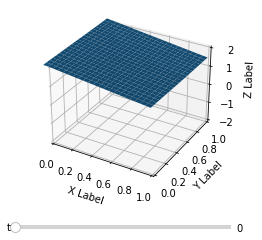

In [5]:
sol=BSDESolver(eqn,{"dtype":torch.float32})
sol.train(2000)
sol.plot_solution()